# Tamil Nadu Climate Change Analysis from 1950-2022 

Data has been collected from the following link: [Climate Data Catalog | World Bank](https://climateknowledgeportal.worldbank.org/download-data)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### The data from 7 different datasets(Wide Format) has been combined into a single dataset using `pandas.melt()` function(Long Format).

In [30]:
# function to load and transform the dataset from wider format to long format
def load_and_melt(csv_path, factor_name):
    # Load the dataset
    df = pd.read_csv(csv_path)
    
    # Select only columns that are in "YYYY-MM" format
    date_columns = [col for col in df.columns if "-" in col and col[:4].isdigit()]
    df = df[["name"] + date_columns]
    
    # Melt the DataFrame to convert it to long format
    df_long = df.melt(id_vars=["name"], var_name="Year-Month", value_name=factor_name)
    
    # Split the "Year-Month" column into "Year" and "Month"
    df_long[['Year', 'Month']] = df_long["Year-Month"].str.split("-", expand=True)
    
    # Convert "Year" and "Month" to integers, handling errors if any
    df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")
    df_long["Month"] = pd.to_numeric(df_long["Month"], errors="coerce")
    
    # Drop rows with invalid "Year" or "Month" values
    df_long.dropna(subset=["Year", "Month"], inplace=True)
    
    # Drop the original "Year-Month" column
    df_long.drop(columns=["Year-Month"], inplace=True)
    
    return df_long

# Load and transform each factor CSV file
factor1_df = load_and_melt("precipitation.csv", "precipitation")
factor2_df = load_and_melt("precipitation50mm.csv", "precipitation50mm")
factor3_df = load_and_melt("precipitation_percentage.csv", "precipitation_percentage")
factor4_df = load_and_melt("maxprecipitation1day.csv", "maxprecipitation1day")
factor5_df = load_and_melt("maxprecipitation5day.csv", "maxprecipitation5day")
factor6_df = load_and_melt("relative_humidity.csv", "relative_humidity")
factor7_df = load_and_melt("maxsurfaceairtemperature.csv", "maxsurfaceairtemperature")

# Merge all factors based
combined_df = factor1_df
for df in [factor2_df, factor3_df, factor4_df, factor5_df, factor6_df, factor7_df]:
    combined_df = pd.merge(combined_df, df, on=["name", "Year", "Month"], how="outer")

# Rename "name" to "State" for clarity
combined_df.rename(columns={"name": "State"}, inplace=True)

# Save the final combined DataFrame
combined_df.to_csv("combined_factors_data.csv", index=False)

#### Extracting Year and Month<br>
Splits the "Year-Month" column into separate "Year" and "Month" columns to group and aggregate data over time.

In [31]:
# Load the dataset
data = pd.read_csv("combined_factors_data.csv")

# Combine "Year" and "Month" columns into a Date column
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
data.set_index('Date', inplace=True)
data.drop(columns=['Year', 'Month'], inplace=True)
data.head()

,State,precipitation,precipitation50mm,precipitation_percentage,maxprecipitation1day,maxprecipitation5day,relative_humidity,maxsurfaceairtemperature
Date,,,,,,,,
1950-01-01,Andaman and Nicobar Islands,30.24,0.00,92.22,13.98,20.78,76.53,25.40
1950-02-01,Andaman and Nicobar Islands,38.05,0.00,152.77,10.19,25.09,78.02,26.09
1950-03-01,Andaman and Nicobar Islands,39.25,0.00,55.55,9.19,31.68,78.27,27.15
1950-04-01,Andaman and Nicobar Islands,105.70,0.00,112.52,33.37,68.87,79.06,27.75
1950-05-01,Andaman and Nicobar Islands,228.05,0.23,88.90,33.23,72.83,83.65,27.49


#### Only Tamil Nadu has been considered for data analysis. The state column has been dropped.

In [32]:
data = data[data['State'] == 'Tamil Nadu']
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 876 entries, 1950-01-01 to 2022-12-01
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   State                     876 non-null    object 
 1   precipitation             876 non-null    float64
 2   precipitation50mm         876 non-null    float64
 3   precipitation_percentage  876 non-null    float64
 4   maxprecipitation1day      876 non-null    float64
 5   maxprecipitation5day      876 non-null    float64
 6   relative_humidity         876 non-null    float64
 7   maxsurfaceairtemperature  876 non-null    float64
dtypes: float64(7), object(1)
memory usage: 61.6+ KB


In [33]:
data.drop("State", axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 876 entries, 1950-01-01 to 2022-12-01
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   precipitation             876 non-null    float64
 1   precipitation50mm         876 non-null    float64
 2   precipitation_percentage  876 non-null    float64
 3   maxprecipitation1day      876 non-null    float64
 4   maxprecipitation5day      876 non-null    float64
 5   relative_humidity         876 non-null    float64
 6   maxsurfaceairtemperature  876 non-null    float64
dtypes: float64(7)
memory usage: 54.8 KB


#### Correlation analysis has been performed on the dataset. 

       precipitation  precipitation50mm  precipitation_percentage  \
count     876.000000         876.000000                876.000000   
mean       82.853699           0.076872                 95.155274   
std        68.032882           0.185443                 81.372375   
min         0.100000           0.000000                  0.410000   
25%        29.942500           0.000000                 50.612500   
50%        68.485000           0.000000                 81.425000   
75%       118.150000           0.060000                119.192500   
max       443.670000           1.750000               1118.620000   

       maxprecipitation1day  maxprecipitation5day  relative_humidity  \
count            876.000000            876.000000         876.000000   
mean              18.077374             42.496667          67.246039   
std               14.453936             32.688844           7.500798   
min                0.040000              0.090000          45.860000   
25%               

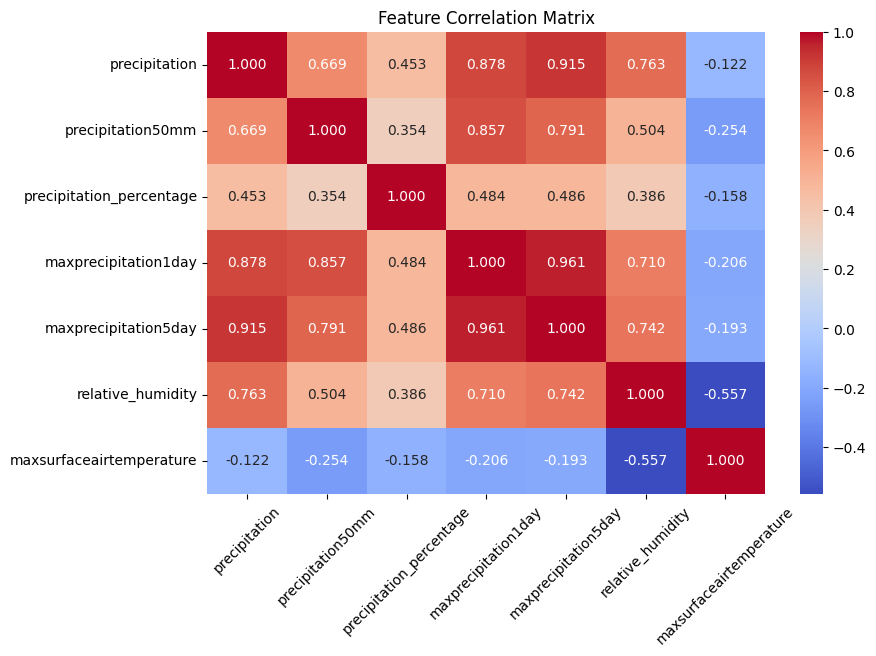

In [34]:
# Summary statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())

# Plot correlations
plt.figure(figsize=(9, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.3f')
plt.title("Feature Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

#### The current features has been plotted against date

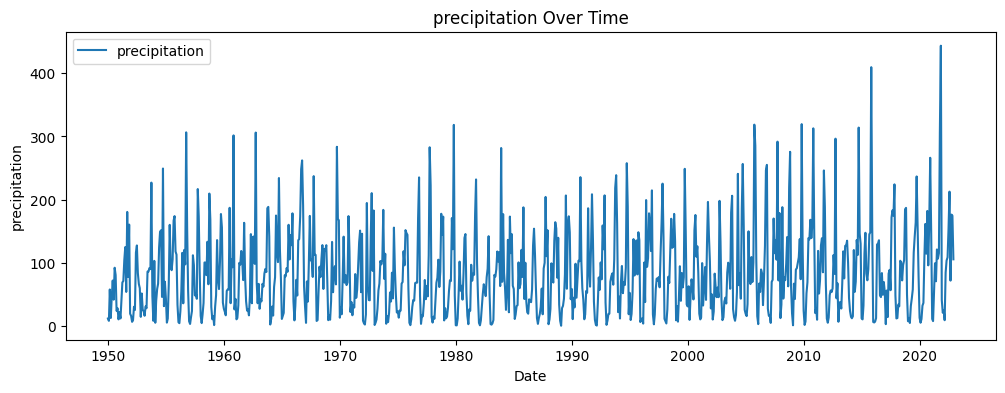

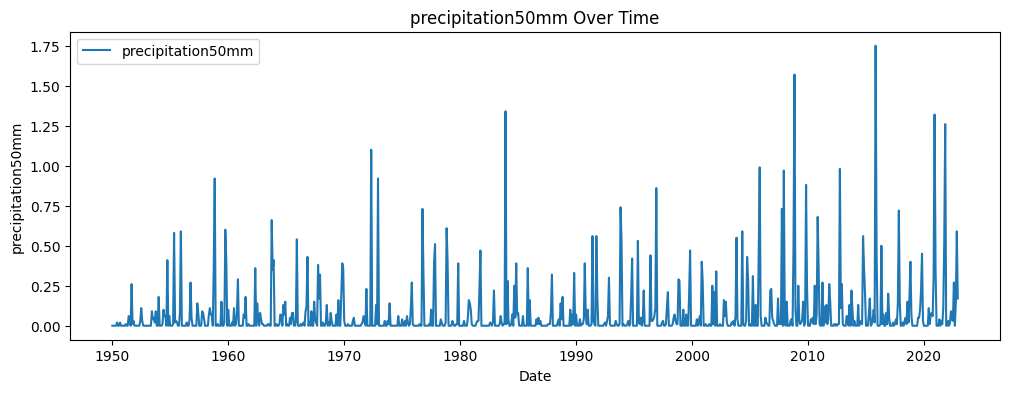

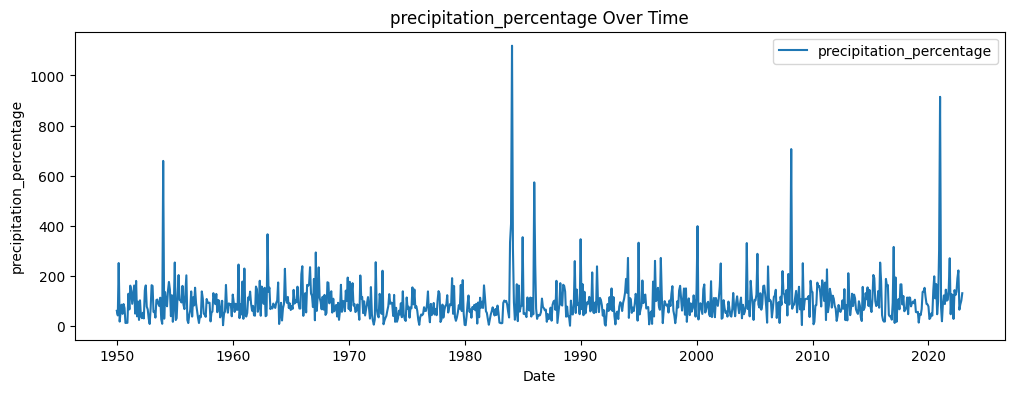

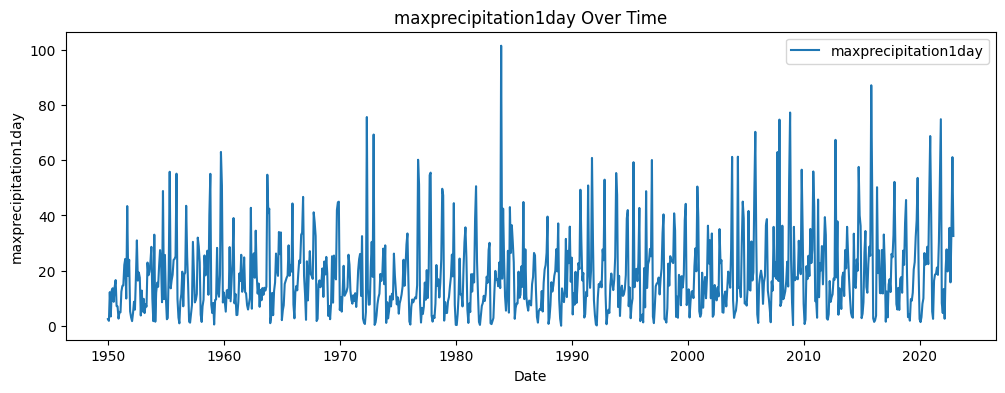

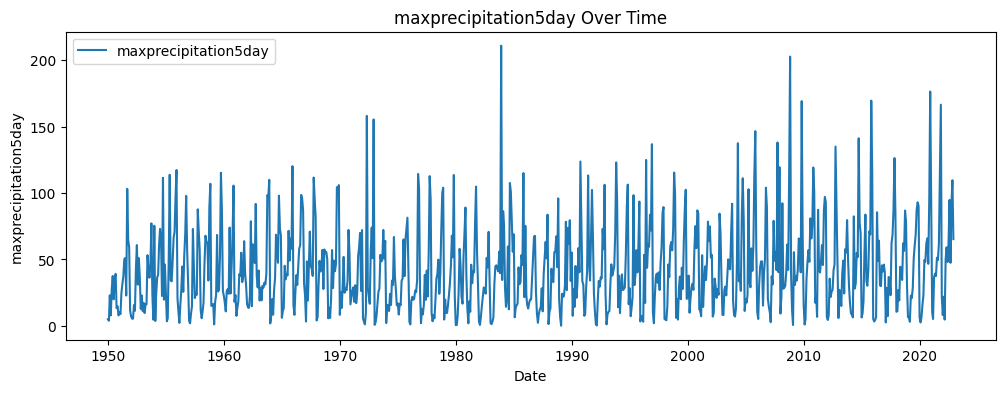

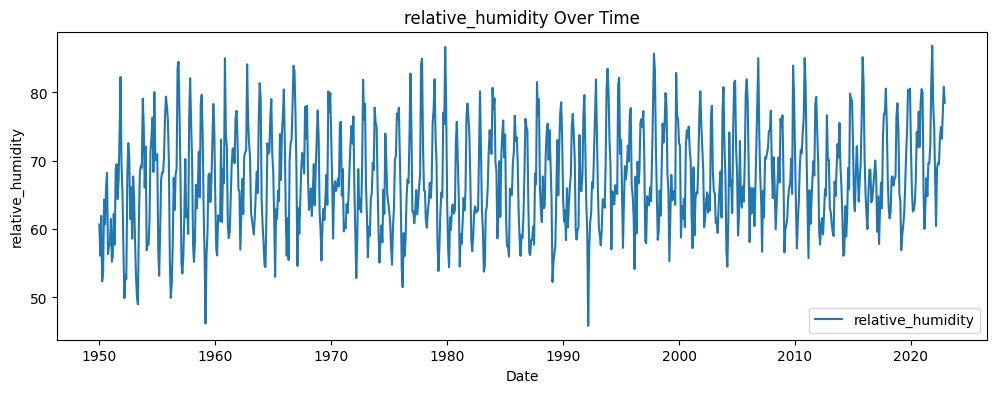

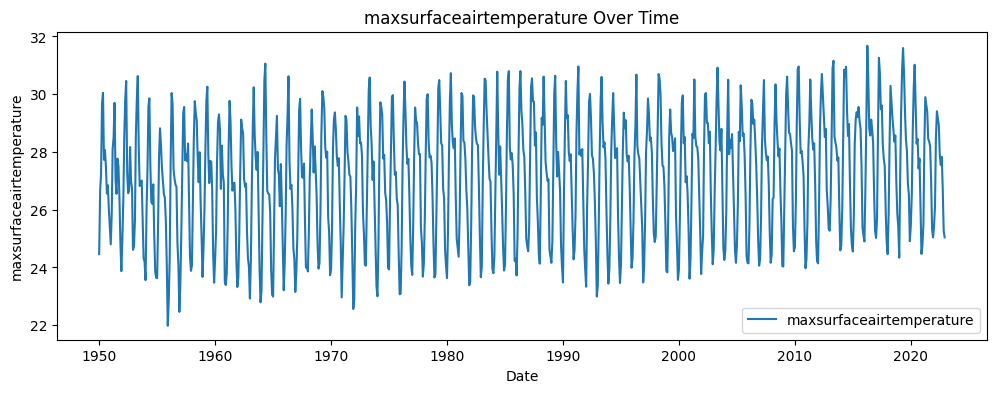

In [35]:
# Plotting each feature over time
for column in data.columns:
    plt.figure(figsize=(12, 4))
    plt.plot(data.index, data[column], label=column)
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.title(f"{column} Over Time")
    plt.legend()
    plt.show()

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 876 entries, 1950-01-01 to 2022-12-01
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   precipitation             876 non-null    float64
 1   precipitation50mm         876 non-null    float64
 2   precipitation_percentage  876 non-null    float64
 3   maxprecipitation1day      876 non-null    float64
 4   maxprecipitation5day      876 non-null    float64
 5   relative_humidity         876 non-null    float64
 6   maxsurfaceairtemperature  876 non-null    float64
dtypes: float64(7)
memory usage: 54.8 KB


#### Data has been split into training and testing datasets
* Training dataset contains data from 1950 - 2020
* Testing dataset contains data from 2021 - 2022

In [37]:
# Splitting data: 1950-2020 for training and 2021-2022 for testing
train_data = data.loc['1950':'2020']
test_data = data.loc['2021':'2022']

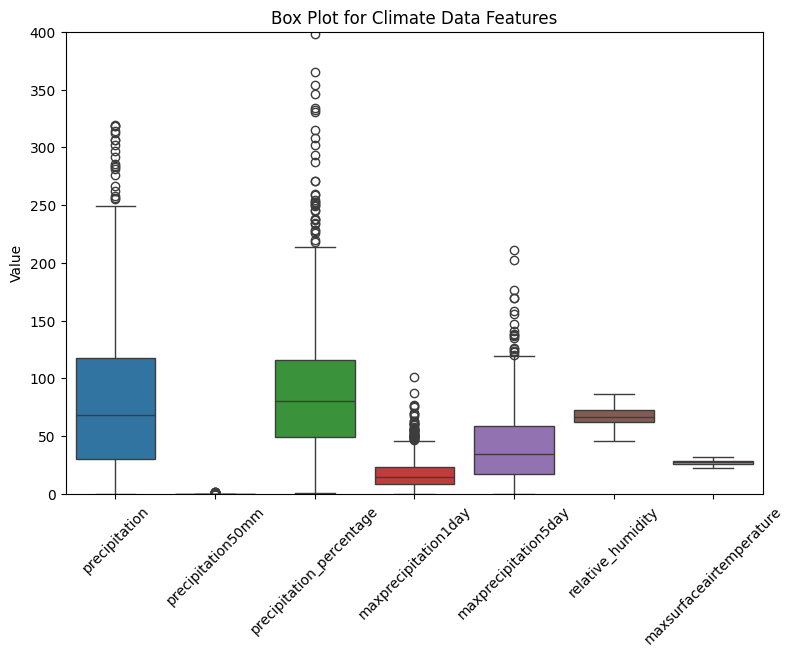

In [38]:
# Box plot for multiple features
plt.figure(figsize=(9, 6))
sns.boxplot(data=train_data[["precipitation", "precipitation50mm", "precipitation_percentage", 
                             "maxprecipitation1day", "maxprecipitation5day", 
                             "relative_humidity", "maxsurfaceairtemperature"]])
plt.title("Box Plot for Climate Data Features")
plt.ylim(0, 400)
plt.xticks(rotation=45)
plt.ylabel("Value")
plt.show()

In [39]:
train_data.head()

,precipitation,precipitation50mm,precipitation_percentage,maxprecipitation1day,maxprecipitation5day,relative_humidity,maxsurfaceairtemperature
Date,,,,,,,
1950-01-01,11.55,0.0,60.02,2.45,4.99,60.67,24.46
1950-02-01,7.81,0.0,41.64,1.81,3.85,56.12,26.68
1950-03-01,57.49,0.0,250.73,12.21,23.01,61.94,27.22
1950-04-01,12.35,0.0,16.91,3.38,7.86,52.36,29.68
1950-05-01,45.79,0.0,56.20,12.87,27.56,53.82,30.05


In [40]:
# Normalization & Standardization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
std_scaler = StandardScaler()

train_std = pd.DataFrame(std_scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
test_std = pd.DataFrame(std_scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

train_normalized = pd.DataFrame(scaler.fit_transform(train_std), columns=train_std.columns, index=train_std.index)
test_normalized = pd.DataFrame(scaler.transform(test_std), columns=test_std.columns, index=test_std.index)

In [41]:
# Apply PCA after normalization
pca = PCA(n_components=4)
train_pca = pca.fit_transform(train_normalized)  # Fit on training data
test_pca = pca.transform(test_normalized)        # Transform test data

# Optional: Convert back to DataFrame for easier handling
train_pca = pd.DataFrame(train_pca, columns=[f'PC{i+1}' for i in range(4)], index=train_normalized.index)
test_pca = pd.DataFrame(test_pca, columns=[f'PC{i+1}' for i in range(4)], index=test_normalized.index)

# Check explained variance ratio
print("Explained variance ratio by each component:", pca.explained_variance_ratio_)

Explained variance ratio by each component: [0.63024358 0.26367206 0.05726406 0.02229054]


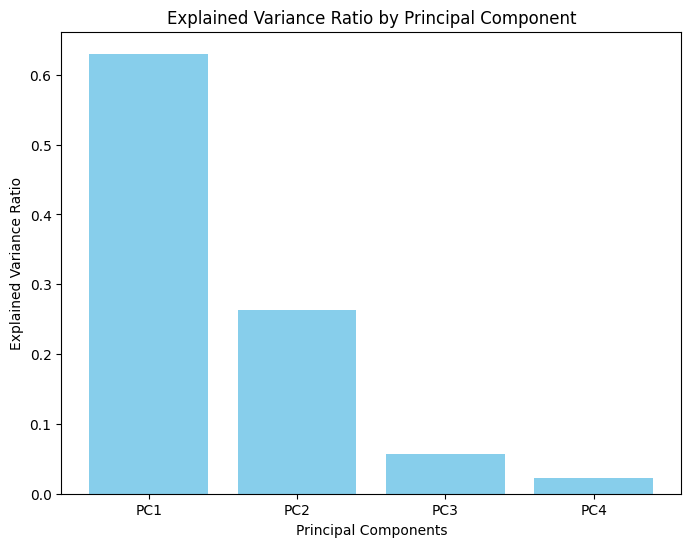

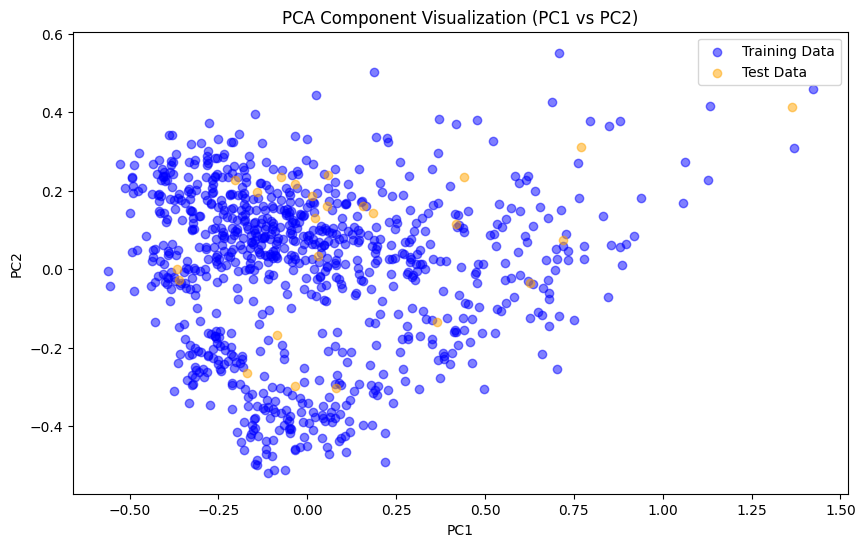

In [42]:
plt.figure(figsize=(8, 6))
plt.bar([f'PC{i+1}' for i in range(4)], pca.explained_variance_ratio_, color='skyblue')
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio by Principal Component")
plt.show()

# Plot the first two principal components for training data
plt.figure(figsize=(10, 6))
plt.scatter(train_pca['PC1'], train_pca['PC2'], alpha=0.5, label='Training Data', color='blue')
plt.scatter(test_pca['PC1'], test_pca['PC2'], alpha=0.5, label='Test Data', color='orange')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Component Visualization (PC1 vs PC2)")
plt.legend()
plt.show()

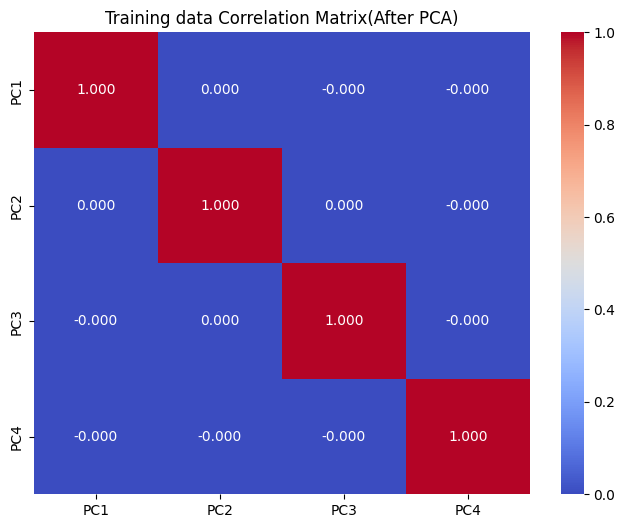

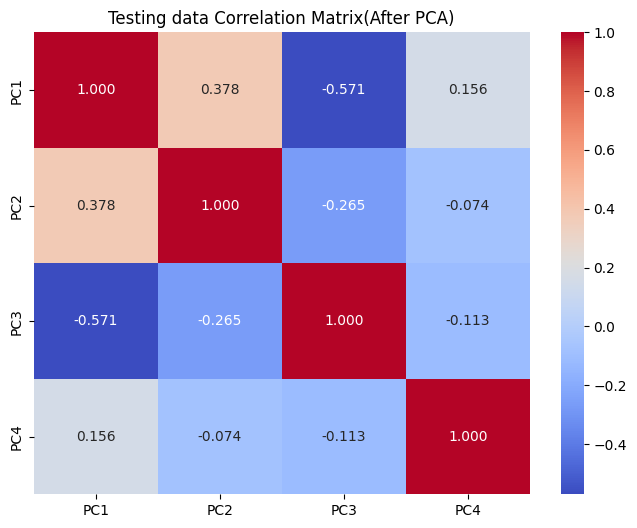

In [43]:
plt.figure(figsize=(8, 6))
sns.heatmap(train_pca.corr(), annot=True, cmap='coolwarm', fmt='.3f')
plt.title("Training data Correlation Matrix(After PCA)")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(test_pca.corr(), annot=True, cmap='coolwarm', fmt='.3f')
plt.title("Testing data Correlation Matrix(After PCA)")
plt.show()

In [44]:
# List of features to predict (all columns except for 'Date')
features = data.columns

# Initialize a dictionary to store predictions
predictions = {feature: {} for feature in features}

# Loop through each feature to train and evaluate a model
for feature in features:
    # Define the target variable for training and testing
    y_train = train_data[feature]
    y_test = test_data[feature]
    
    # Train Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(train_pca, y_train)
    y_pred_lr = lr_model.predict(test_pca)
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(train_pca, y_train)
    y_pred_rf = rf_model.predict(test_pca)
    
    # Store predictions in the dictionary
    predictions[feature]['y_test'] = y_test
    predictions[feature]['y_pred_lr'] = y_pred_lr
    predictions[feature]['y_pred_rf'] = y_pred_rf
    
    # Print performance metrics for each model
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    print(f"{feature} - Linear Regression - MSE: {mse_lr:.4f}, R2: {r2_lr:.4f}")
    
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    print(f"{feature} - Random Forest - MSE: {mse_rf:.4f}, R2: {r2_rf:.4f}")

precipitation - Linear Regression - MSE: 821.1390, R2: 0.9139
precipitation - Random Forest - MSE: 897.9175, R2: 0.9059
precipitation50mm - Linear Regression - MSE: 0.0077, R2: 0.9028
precipitation50mm - Random Forest - MSE: 0.0030, R2: 0.9620
precipitation_percentage - Linear Regression - MSE: 525.0702, R2: 0.9816
precipitation_percentage - Random Forest - MSE: 946.1776, R2: 0.9668
maxprecipitation1day - Linear Regression - MSE: 16.5104, R2: 0.9479
maxprecipitation1day - Random Forest - MSE: 9.2256, R2: 0.9709
maxprecipitation5day - Linear Regression - MSE: 67.4269, R2: 0.9552
maxprecipitation5day - Random Forest - MSE: 26.6950, R2: 0.9823
relative_humidity - Linear Regression - MSE: 3.0695, R2: 0.9327
relative_humidity - Random Forest - MSE: 4.1949, R2: 0.9081
maxsurfaceairtemperature - Linear Regression - MSE: 0.0425, R2: 0.9846
maxsurfaceairtemperature - Random Forest - MSE: 0.0822, R2: 0.9702


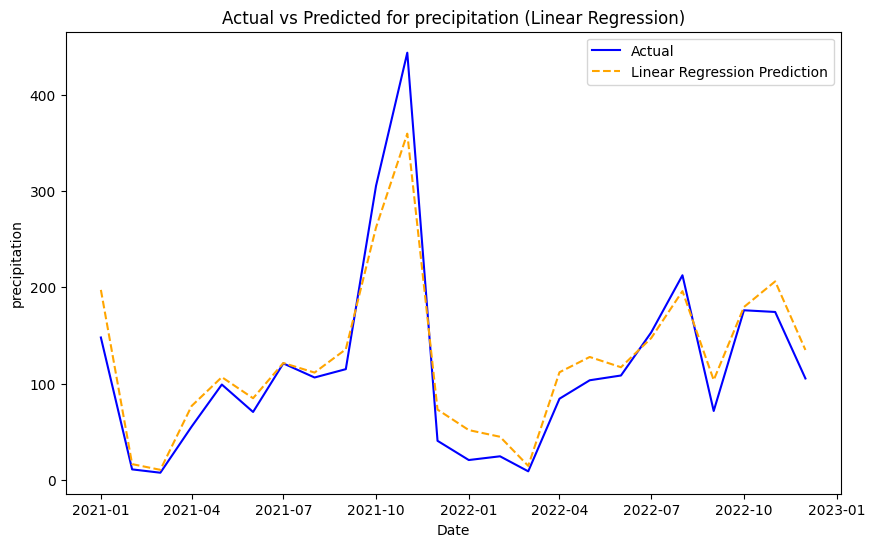

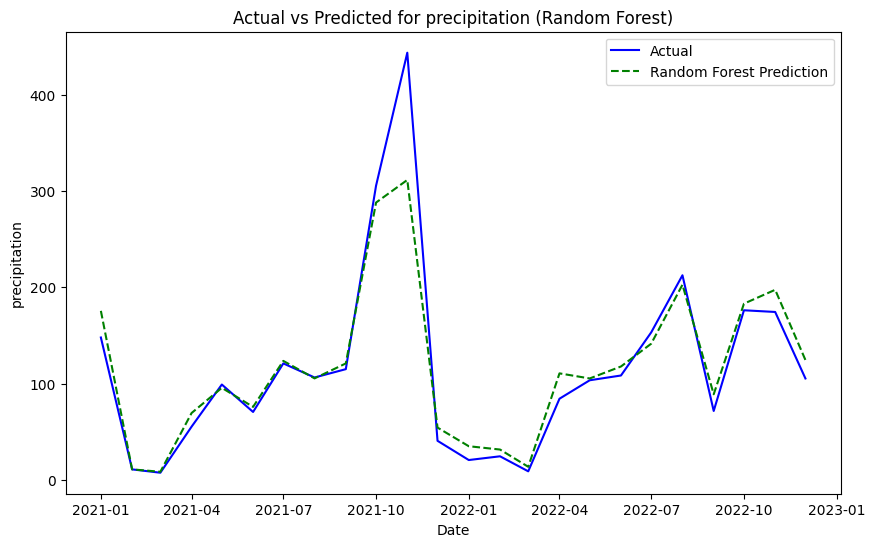

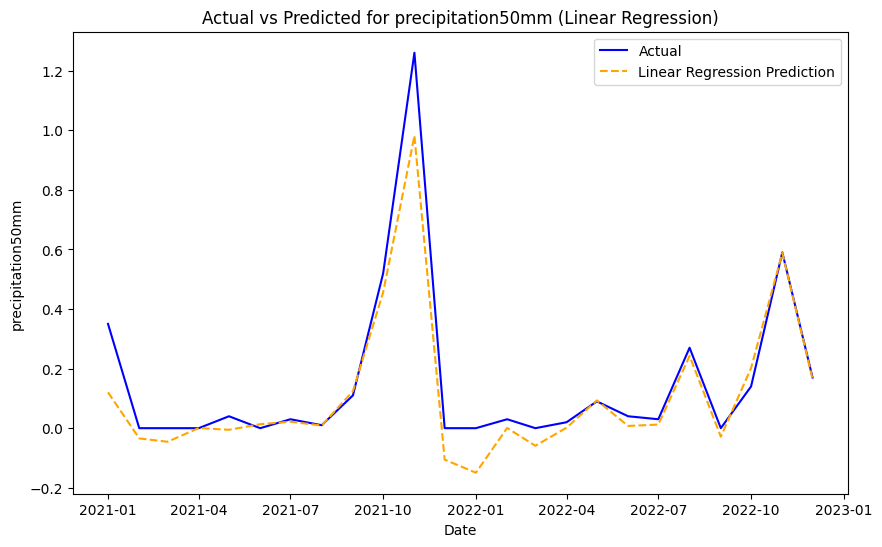

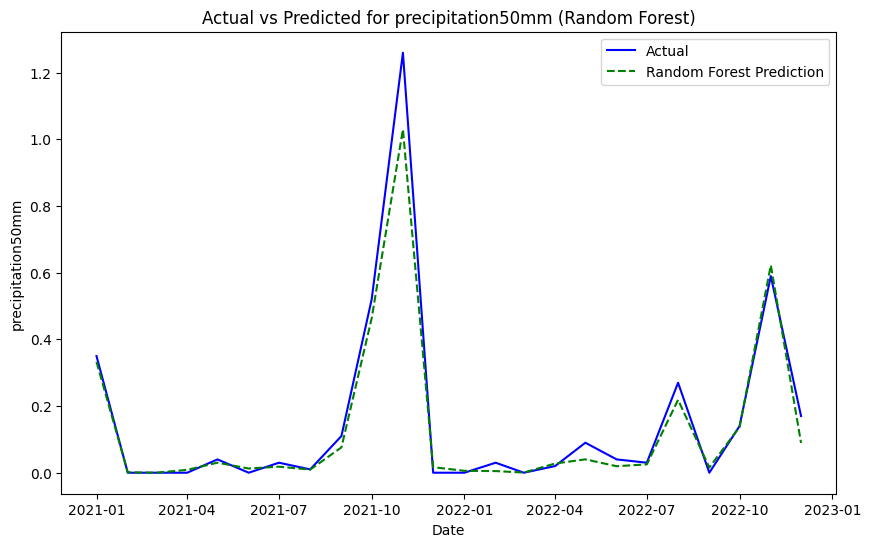

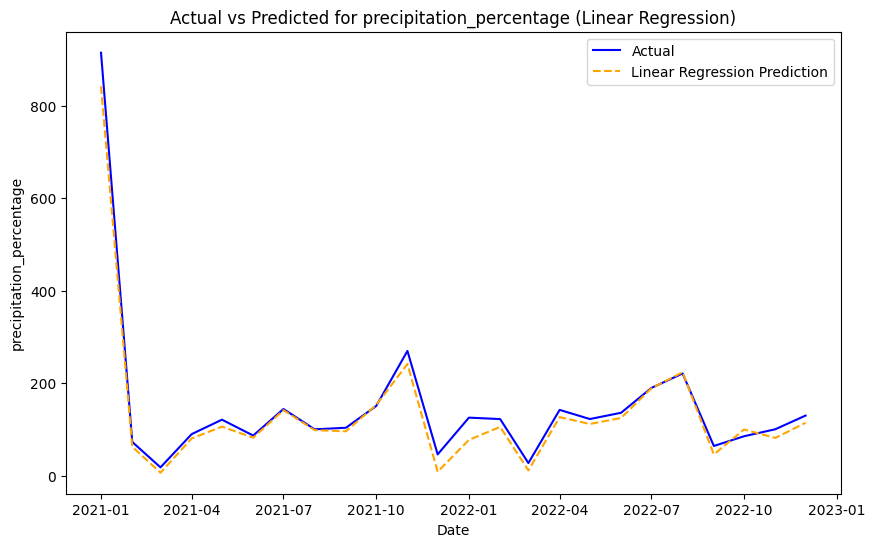

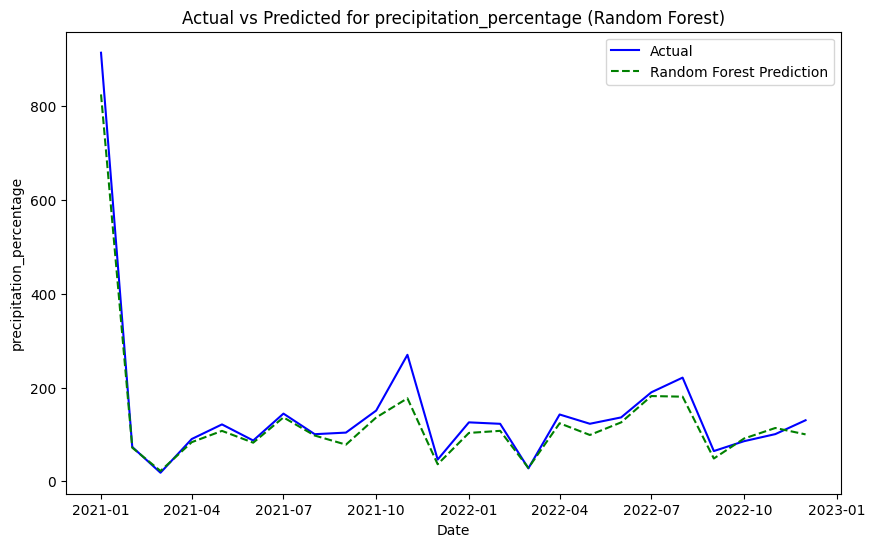

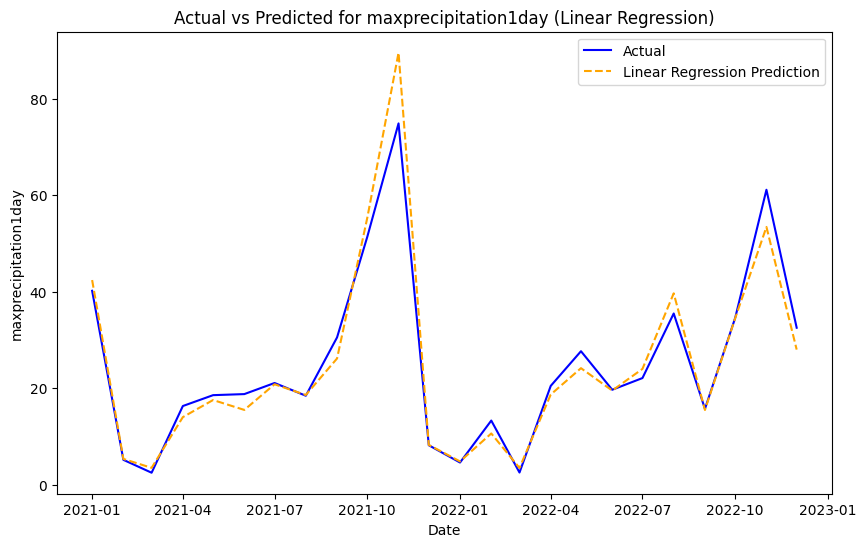

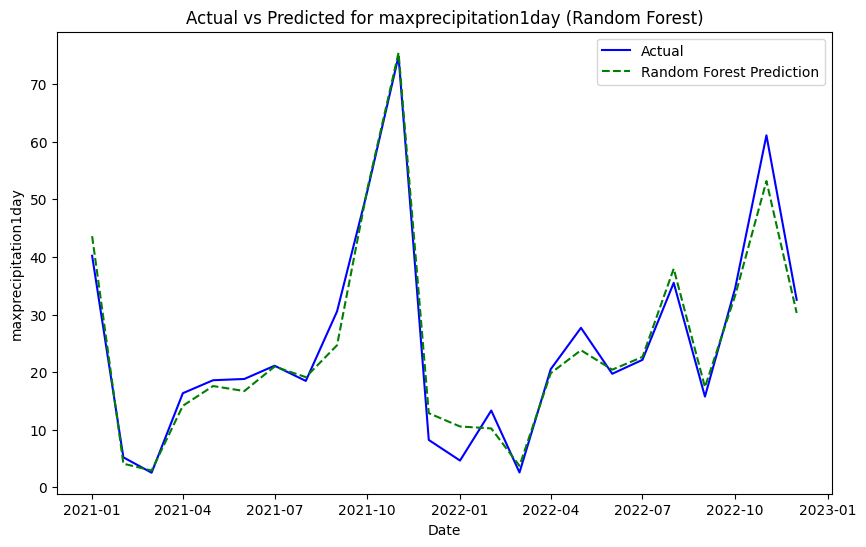

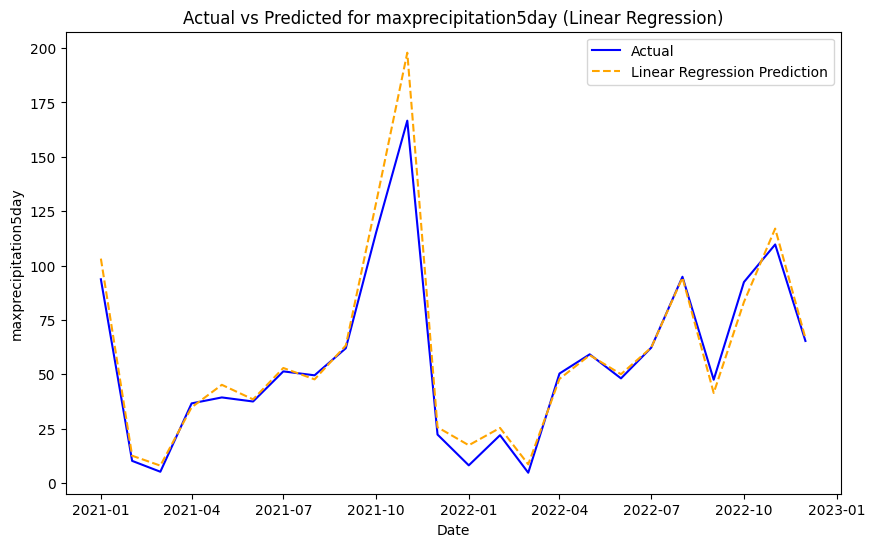

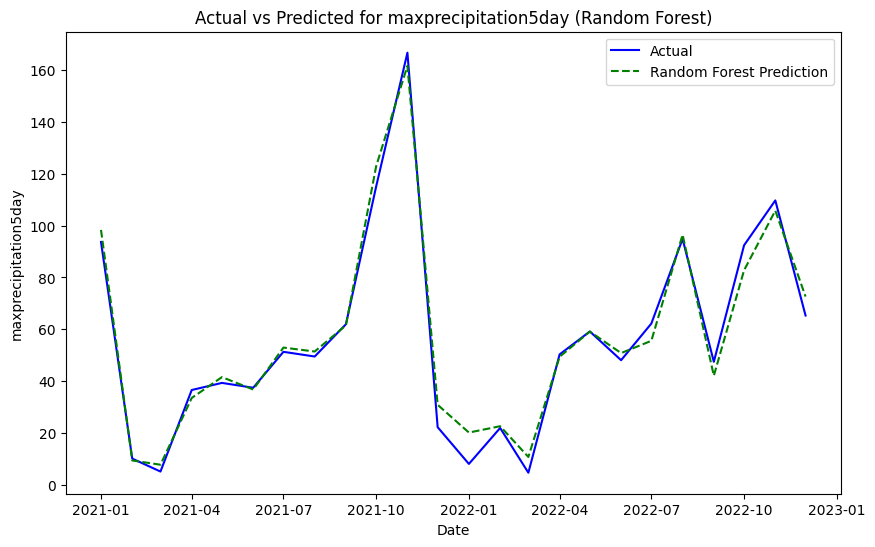

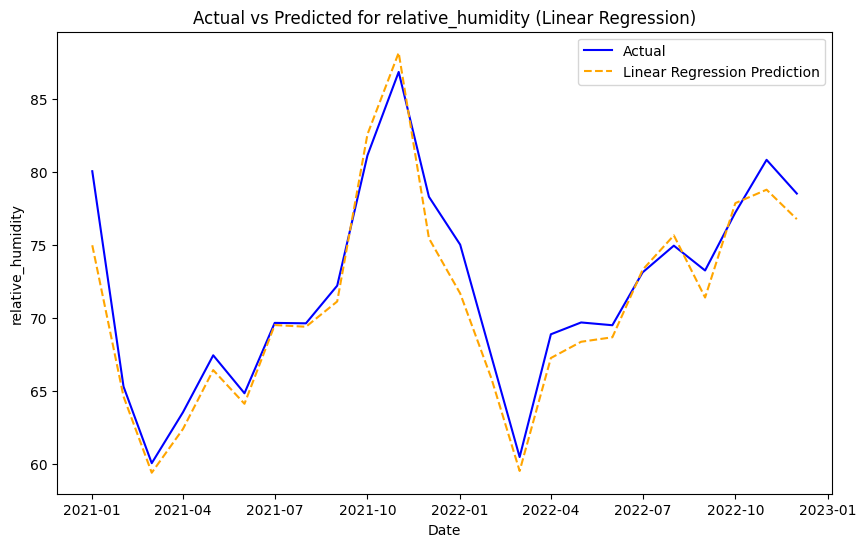

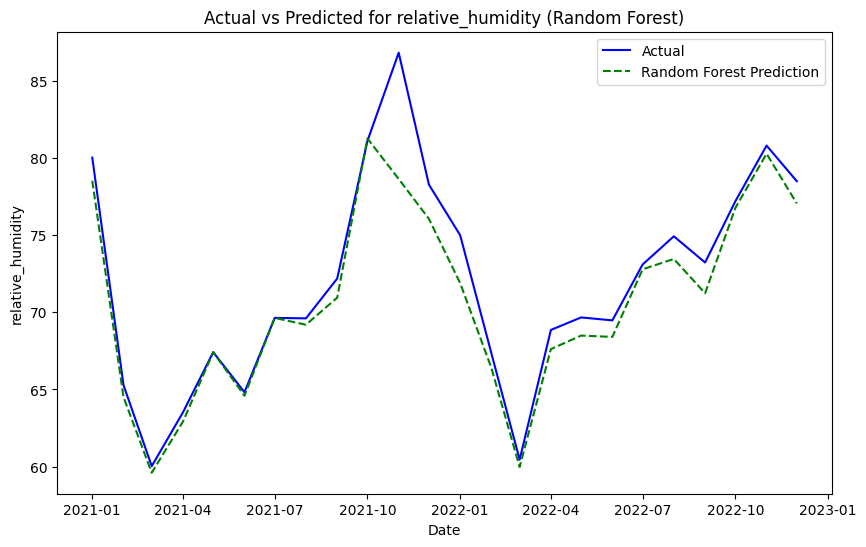

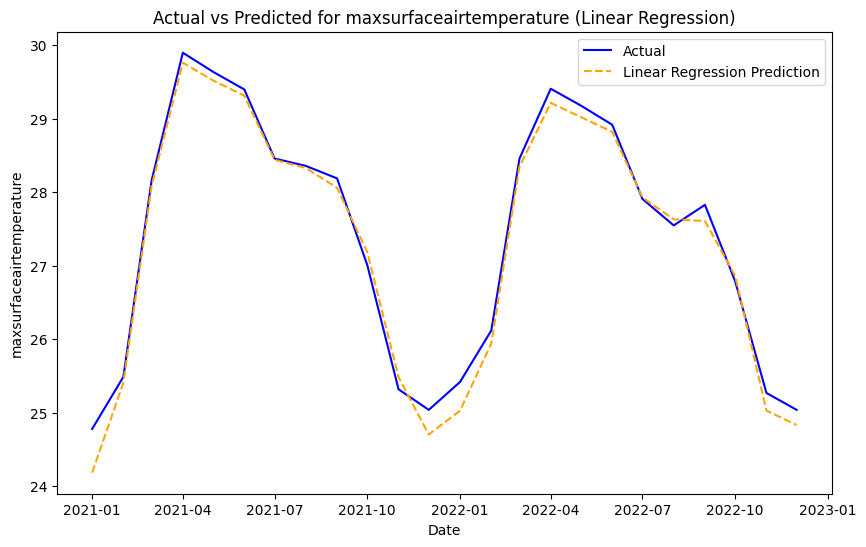

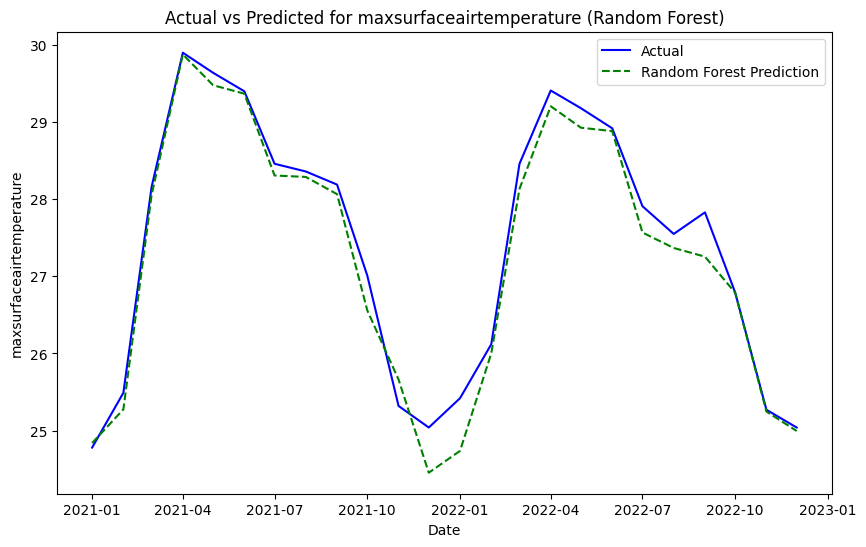

In [45]:
# Plot actual vs predicted values for each feature
for feature in features:
    y_test = predictions[feature]['y_test']
    y_pred_lr = predictions[feature]['y_pred_lr']
    y_pred_rf = predictions[feature]['y_pred_rf']
    
    # Plot for Linear Regression
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label="Actual", color="blue")
    plt.plot(y_test.index, y_pred_lr, label="Linear Regression Prediction", color="orange", linestyle="--")
    plt.title(f"Actual vs Predicted for {feature} (Linear Regression)")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.legend()
    plt.show()
    
    # Plot for Random Forest
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label="Actual", color="blue")
    plt.plot(y_test.index, y_pred_rf, label="Random Forest Prediction", color="green", linestyle="--")
    plt.title(f"Actual vs Predicted for {feature} (Random Forest)")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.legend()
    plt.show()


In [46]:
lr_box = {}
rf_box = {}
for key, value in predictions.items():
    lr_box[key] = value['y_pred_lr']
    rf_box[key] = value['y_pred_rf']

lr_box_df = pd.DataFrame(lr_box)
rf_box_df = pd.DataFrame(rf_box)

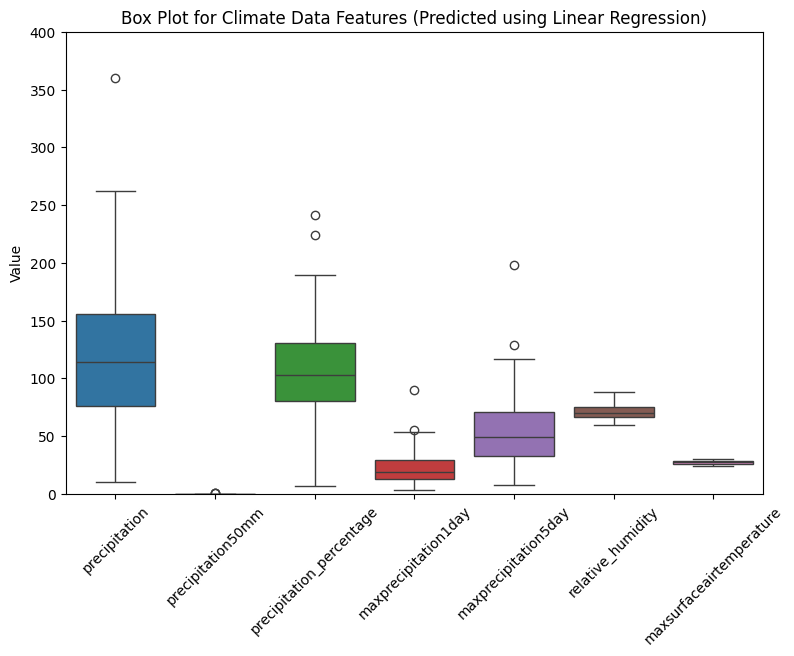

In [47]:
# Box plot for multiple features
plt.figure(figsize=(9, 6))
sns.boxplot(data=lr_box_df)
plt.title("Box Plot for Climate Data Features (Predicted using Linear Regression)")
plt.ylim(0, 400)
plt.xticks(rotation=45)
plt.ylabel("Value")
plt.show()

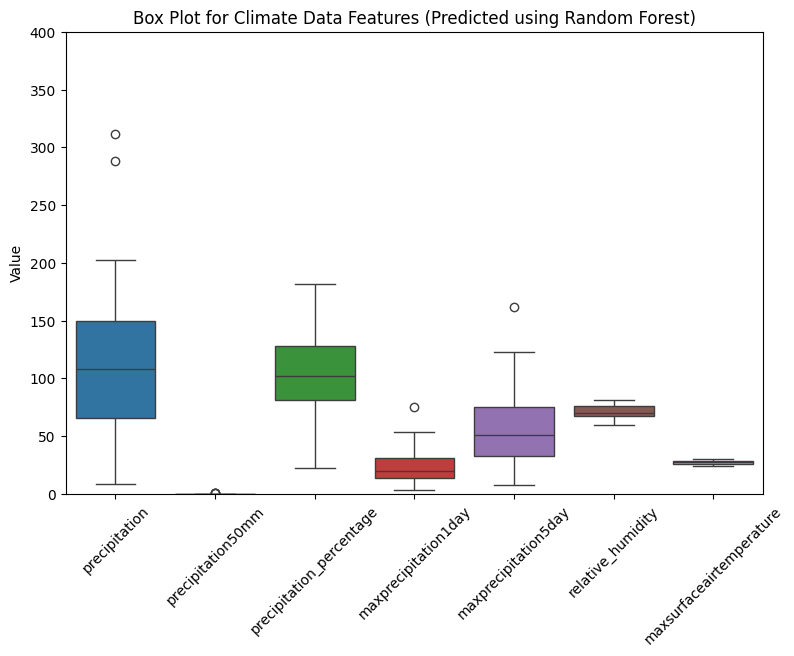

In [48]:
# Box plot for multiple features
plt.figure(figsize=(9, 6))
sns.boxplot(data=rf_box_df)
plt.title("Box Plot for Climate Data Features (Predicted using Random Forest)")
plt.ylim(0, 400)
plt.xticks(rotation=45)
plt.ylabel("Value")
plt.show()